In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

# %pip install rasterio
# %pip install imageio
# %pip install fiona
# %pip install geopandas
# %pip install earthpy
# %pip install Pillow
# %pip install gdal
# %pip install tifffile
# %pip install imagecodecs

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import imageio
import rasterio
from rasterio.plot import show
from rasterio.transform import from_origin
from rasterio.coords import disjoint_bounds
from rasterio.windows import from_bounds
from rasterio.windows import Window
from rasterio.warp import reproject, Resampling
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
from rasterio import mask
from rasterio.features import geometry_mask
from rasterio import features
from rasterio.enums import MergeAlg

from rasterio.warp import calculate_default_transform, reproject, Resampling
import pyproj

import geopandas as gpd

from osgeo import gdal
import matplotlib.pyplot as mplot
import numpy as np
from numpy import int16

from PIL import Image

import cv2
import numpy as np
from google.colab.patches import cv2_imshow

import fiona
import geopandas as gpd
from shapely.geometry import box

import os
import matplotlib.pyplot as plt
import earthpy as et
import earthpy.plot as ep

import math
import shutil
import gc

#### Create shape raster(s)





##### Check if needs to be resampled or reprojected

In [ ]:
# List rasters
root_dir = "gdrive/My Drive/Stage/Data/Input/Train"
rasterpaths = sorted([f for f in os.listdir(os.path.join(root_dir, "Rasters")) if f.lower().endswith(('.tif', '.tiff'))])
rasterpath = rasterpaths[0]

with rasterio.open(os.path.join(root_dir, "Rasters", rasterpath)) as src:
    print(src.res[0], "/", src.res[1], "=", src.res[0]/src.res[1])
    print(src.crs)

def needs_resample(path):
    with rasterio.open(os.path.join(root_dir, "Rasters", rasterpath)) as src:

        if src.res[0] < 0.001 or src.res[1] < 0.001:
          resample = "Grid size very small, check if correct."

        elif (src.res[0]/src.res[1]) > 0.99 and (src.res[0]/src.res[1]) < 1.01:
          resample = "no"
          # print("X and Y are near equal so no resample")
        else:
          resample = "yes"
          # print("X and Y are not equal so resample")

        return resample

def needs_reproject(path):
    with rasterio.open(os.path.join(root_dir, "Rasters", rasterpath)) as src:

        if src.crs == None:
          reproject = "yes (do in ArcGIS Pro)"
        else:
          reproject = "no"

        return reproject

print("needs resample:", needs_resample(rasterpath))
print("needs reproject:", needs_reproject(rasterpath))

0.018785975253346417 / 0.018785975253433555 = 0.9999999999953615


'no'

##### Convert

In [ ]:
# List rasters
root_dir = "gdrive/My Drive/Stage/Data/Input/Train"
rasterpaths = sorted([f for f in os.listdir(os.path.join(root_dir, "Rasters")) if f.lower().endswith(('.tif', '.tiff'))])
shapepaths = sorted([f for f in os.listdir(os.path.join(root_dir, "Shapes/PureShapes")) if f.lower().endswith(('.shp'))])

# Assuming rasters, shapes, points have same naming convention
# Because of sizes, you may not have all rasters uploaded
# Therefore, loop only over gdfs that have a corresponding raster, for this find index

index_list = []
for rasterpath in rasterpaths:
  rastername = rasterpath[:-4] # without .tif extension
  index = next((index for index, item in enumerate(shapepaths) if rastername in item), None)
  index_list.append(index)

for index, rasterpath in zip(index_list, rasterpaths):

    if index is None:
      print("No", rastername + ".shp")
      break

    gdf = gpd.read_file(os.path.join(root_dir, "Shapes/PureShapes", shapepaths[index])) # load corresponding gdf
    resample = needs_resample(rasterpath) # Check if raster needs to be resampled

    with rasterio.open(os.path.join(root_dir, "Rasters", rasterpath)) as src:

        if resample == "yes":

            # ---------------------------------------------------------------- #
            # Resample grid size so that X and Y lengths are similar
            # ---------------------------------------------------------------- #

            # Current grid sizes
            scale_factor_x = src.res[0]
            scale_factor_y = src.res[1]

            # Resample to largest size
            if scale_factor_x > scale_factor_y:
              scale_factor = scale_factor_x
            else:
              scale_factor = scale_factor_y

            profile = src.profile.copy()
            # resample data to target shape
            data = src.read(
                out_shape=(
                    src.count,
                    int(dataset.height * scale_factor),
                    int(dataset.width * scale_factor)
                ),
                resampling=Resampling.bilinear
            )

            # scale image transform
            transform = src.transform * src.transform.scale(
                (1 / scale_factor),
                (1 / scale_factor)
            )
            profile.update({"height": data.shape[-2],
                            "width": data.shape[-1],
                          "transform": transform})

            os.makedirs(os.path.join(root_dir, "Rasters/Resampled"), exist_ok=True) # Save resampled rasters in 'Resampled' folder
            with rasterio.open(os.path.join(root_dir, "Rasters/Resampled", rasterpath), "w", **profile) as dataset:
                dataset.write(data)

            dataset = rasterio.open(os.path.join(root_dir, "Rasters/Resampled", rasterpath))
            src = dataset

        # ---------------------------------------------------------------- #
        # If you want, reproject the raster to match the CRS of the shapefile
        # ---------------------------------------------------------------- #

        # # Get the CRS of the shapefile
        # target_crs = gdf.crs

        # transform, width, height = calculate_default_transform(src.crs, target_crs, src.width, src.height, *src.bounds)

        # kwargs = src.meta.copy()
        # kwargs.update({
        #     'crs': target_crs,
        #     'transform': transform,
        #     'width': width,
        #     'height': height
        # })

        # os.makedirs(os.path.join(root_dir, "Rasters/Reprojected"), exist_ok=True) # Save reprojected rasters in 'Reprojected' folder
        # with rasterio.open(os.path.join(root_dir, "Rasters/Reprojected", rasterpath), 'w', **kwargs) as dst:
        #     for i in range(1, src.count + 1):
        #         reproject(
        #             source=rasterio.band(src, i),
        #             destination=rasterio.band(dst, i),
        #             src_transform=src.transform,
        #             src_crs=src.crs,
        #             dst_transform=transform,
        #             dst_crs=target_crs,
        #             resampling=Resampling.nearest
        #         )

        # # Load reprojected raster
        # dst = rasterio.open(os.path.join(root_dir, "Rasters/Reprojected", rasterpath))
        # src = dst

        # ---------------------------------------------------------------- #
        # Create a new shape raster
        # ---------------------------------------------------------------- #

        # Change gdf crs to that of the raster
        target_crs = src.crs # you may need to transform in ArcGIS Pro (check if align here later)
        gdf = gdf.to_crs(target_crs)

        mask_raster = np.zeros_like(src.read(1)) # 0 will mean there is no bird

        # Generate masks based on the species
        mask = geometry_mask(gdf.geometry, out_shape=mask_raster.shape, transform=src.transform, invert=True)
        mask_raster[mask] = 1 # 1 means there is a bird, whatever the species

        # Save the new raster
        os.makedirs(os.path.join(root_dir, "ShapeRasters"), exist_ok=True) # Save new raster in 'ShapeRasters' folder
        profile = src.profile
        profile.update(count=1, dtype='uint8', nodata=None)  # Remove nodata value
        with rasterio.open(os.path.join(root_dir, "ShapeRasters", rasterpath), 'w', **profile) as newr:
            newr.write(mask_raster.astype('uint8'), 1)


## Tile

In [ ]:
# One at a time to save memory (may need to restart runtime)

root_dir = "gdrive/My Drive/Stage/Data/Input/Train"
rasterpaths = sorted([f for f in os.listdir(os.path.join(root_dir, "Rasters")) if f.lower().endswith(('.tif', '.tiff'))])
rname = rasterpaths[0]

resample = needs_resample(rname)
if resample == "yes":
    imgpath = os.path.join(root_dir, "Rasters/Resampled", rname)
else:
    imgpath = os.path.join(root_dir, "Rasters", rname)
maskpath = os.path.join(root_dir, "ShapeRasters", rname)

# Open with GDAL
raster_data_set = gdal.Open(imgpath)
mask_data_set = gdal.Open(maskpath)

# Get cell size
gt = raster_data_set.GetGeoTransform()
pixelSizeX = gt[1]

# Convert to array image
raster_band_1 = raster_data_set.GetRasterBand(1) # red channel
raster_band_2 = raster_data_set.GetRasterBand(2) # green channel
raster_band_3 = raster_data_set.GetRasterBand(3) # blue channel
mask_band_1 = mask_data_set.GetRasterBand(1) # first/only channel

too_large = "No" # if too large, read only a specified amount
if too_large == "Yes":

    # If the dataset is too large: Specify the subset parameters (adjust these as needed)
    xoff = 0  # starting column
    yoff = 0  # starting row
    xsize = int(2 * raster_data_set.RasterXSize / 3) # 2 * raster_data_set.RasterXSize / 3 = 2/3 of image
    ysize = int(5 * raster_data_set.RasterYSize / 10)

    raster_b1 = raster_band_1.ReadAsArray(xoff, yoff, xsize, ysize)
    raster_b2 = raster_band_2.ReadAsArray(xoff, yoff, xsize, ysize)
    raster_b3 = raster_band_3.ReadAsArray(xoff, yoff, xsize, ysize)
    mask_b1 = mask_band_1.ReadAsArray(xoff, yoff, xsize, ysize)

else:
    # Convert to array image
    raster_b1 = raster_band_1.ReadAsArray()
    raster_b2 = raster_band_2.ReadAsArray()
    raster_b3 = raster_band_3.ReadAsArray()
    mask_b1 = mask_band_1.ReadAsArray()

# Stack to image
raster_img = np.dstack((raster_b1, raster_b2, raster_b3))
mask_img = np.dstack((mask_b1))
mask_img = mask_img[0].T # Transpose because axis was inverted (why?)


In [ ]:
# cell size of Texel PHZ
target_cs = 0.011272670412636411

# WxH tile pixel size (depending on cell size)
W = round(890 * (target_cs/pixelSizeX)) # ~ 10.0 m x 10.0 m # was 1000
H = round(445 * (target_cs/pixelSizeX)) # ~ 5.0 m x 5.0 m # was 350

# Split in to M and N tiles
raster_tiles_W = [raster_img[x:x+W,y:y+W] for x in range(0,raster_img.shape[0],W) for y in range(0,raster_img.shape[1],W)]
mask_tiles_W = [mask_img[x:x+W,y:y+W] for x in range(0,mask_img.shape[0],W) for y in range(0,mask_img.shape[1],W)]

raster_tiles_H = [raster_img[x:x+H,y:y+H] for x in range(0,raster_img.shape[0],H) for y in range(0,raster_img.shape[1],H)]
mask_tiles_H = [mask_img[x:x+H,y:y+H] for x in range(0,mask_img.shape[0],H) for y in range(0,mask_img.shape[1],H)]

print("Total", W, "pixel size tiles:", len(raster_tiles_W))
print("Total", H, "pixel size tiles:", len(raster_tiles_H))

Total 600 pixel size tiles: 12
Total 210 pixel size tiles: 81


#### Remove % tiles with no birds

In [ ]:
import random

def shuffle_similarly(list1, list2):
    combined = list(zip(list1, list2))
    random.shuffle(combined)
    shuffled_list1, shuffled_list2 = zip(*combined)
    return list(shuffled_list1), list(shuffled_list2)

def filter_tiles(raster_tiles, mask_tiles, bg_keep_pc):

    # # Remove tiles with NoData (black borders)
    # for i in range(len(raster_tiles)):

    #   # Value 0 = black (but sometimes < 0  or > 256)
    #   if (raster_tiles[i] == 0).any() or (raster_tiles[i] < 0).any() or (raster_tiles[i] > 256).any():
    #     raster_tiles[i] = None
    #     mask_tiles[i] = None

    # Filter
    # raster_tiles = [tile for tile in raster_tiles if tile is not None]
    # mask_tiles = [tile for tile in mask_tiles if tile is not None]

    # Filter based on tiles where there are no masks (birds)
    bird_raster_tiles = []
    bird_mask_tiles = []
    no_bird_raster_tiles = []
    no_bird_mask_tiles = []

    for i in range(len(raster_tiles)):

      mask_tile_img = mask_tiles[i].copy()
      contours, _ = cv2.findContours(mask_tile_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

      if contours == ():
        no_bird_raster_tiles.append(raster_tiles[i])
        no_bird_mask_tiles.append(mask_tiles[i])

      else:
        bird_raster_tiles.append(raster_tiles[i])
        bird_mask_tiles.append(mask_tiles[i])

    # Filter a percentage of the no bird tiles (to reduce dataset)
    remove_count = len(no_bird_raster_tiles) * (100 - bg_keep_pc) // 100
    indices_to_remove = random.sample(range(len(no_bird_raster_tiles)), remove_count)
    no_bird_raster_tiles = [item for i, item in enumerate(no_bird_raster_tiles) if i not in indices_to_remove]
    no_bird_mask_tiles = [item for i, item in enumerate(no_bird_mask_tiles) if i not in indices_to_remove]

    # Concat and shuffle
    raster_tiles = bird_raster_tiles + no_bird_raster_tiles
    mask_tiles = bird_mask_tiles + no_bird_mask_tiles

    if len(raster_tiles) != 0 and len(mask_tiles) != 0:
      raster_tiles, mask_tiles = shuffle_similarly(raster_tiles, mask_tiles)
      print("After filtering", len(raster_tiles), "tiles")
      return raster_tiles, mask_tiles
    else:
      print("No tiles. Perhaps there were no birds masked.")
      return None, None

    # If too many, use only certain fraction
    # raster_tiles = raster_tiles[:int(len(raster_tiles) * 0.1)]
    # mask_tiles = mask_tiles[:int(len(mask_tiles) * 0.1)]
    # print("Using", len(raster_tiles), "tiles")

# Tile
raster_tiles_W0, mask_tiles_W0 = filter_tiles(raster_tiles_W, mask_tiles_W, 0) # keep 0% (remove all tiles with only background)
raster_tiles_H0, mask_tiles_H0 = filter_tiles(raster_tiles_H, mask_tiles_H, 0)

raster_tiles_W10, mask_tiles_W10 = filter_tiles(raster_tiles_W, mask_tiles_W, 10) # keep 10% of bg
raster_tiles_H10, mask_tiles_H10 = filter_tiles(raster_tiles_H, mask_tiles_H, 10)


After filtering 9 tiles
After filtering 30 tiles
After filtering 10 tiles
After filtering 36 tiles


#### Check
if bad or misaligned, don't add to training data

*   Reproject/transform (in e.g., ArcGIS Pro or in Python above)
*   Resample: make sure X and Y cell size is equal (in e.g., ArcGIS Pro or in Python above)
*   No compression: make sure there is no compression (reproject in ArcGIS Pro --> environment)







11


(-0.5, 209.5, 209.5, -0.5)

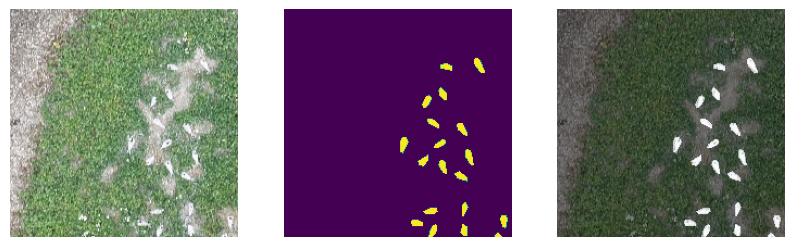

In [ ]:
# Check if raster and mask tiles correspond / make sense
import random

# Which to check
raster_tocheck = raster_tiles_H0
mask_tocheck = mask_tiles_H0

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# See random tile
tile_numb = random.randint(0, len(raster_tocheck)-1)
print(tile_numb)

# Plot the images
axs[0].imshow(raster_tocheck[tile_numb].astype(np.uint8))
axs[0].axis('off')  # Turn off axis labels and ticks
axs[1].imshow(mask_tocheck[tile_numb].astype(np.uint8))
axs[1].axis('off')

# Overlay the mask on the raster
axs[2].imshow(raster_tocheck[tile_numb].astype(np.uint8), cmap='viridis')  # Change cmap if needed
axs[2].imshow(mask_tocheck[tile_numb].astype(np.uint8), alpha=0.5, cmap='gray')  # Adjust alpha as needed
axs[2].axis('off')

## Write images, masks and annotations to file

In [ ]:
# For each tile, write to file and create annotations

# Out paths
root_path = "gdrive/My Drive/Stage/Data/Input/Ready"
rastername = rname[:-4] # pass raster name as identifier

def write2data(raster_tiles, mask_tiles, size_t, keep_pc):

    for i in range(len(raster_tiles)):

      # Make directories if not exist
      os.makedirs(os.path.join(root_path, str(size_t)), exist_ok=True)
      os.makedirs(os.path.join(root_path, str(size_t), str(keep_pc) + "bg"), exist_ok=True)
      os.makedirs(os.path.join(root_path, str(size_t), str(keep_pc) + "bg", "Images"), exist_ok=True)
      os.makedirs(os.path.join(root_path, str(size_t), str(keep_pc) + "bg", "Masks"), exist_ok=True)
      os.makedirs(os.path.join(root_path, str(size_t), str(keep_pc) + "bg", "Annotations"), exist_ok=True)

      # Out paths
      out_img_path = os.path.join(root_path, str(size_t), str(keep_pc) + "bg", "Images/")
      out_mask_path = os.path.join(root_path, str(size_t), str(keep_pc) + "bg", "Masks/")
      out_anno_path = os.path.join(root_path, str(size_t), str(keep_pc) + "bg", "Annotations/")

      # Output path
      out_img = out_img_path + rastername + "_img" + str(i+1) + ".png"
      out_mask = out_mask_path + rastername + "_mask" + str(i+1) + ".png"
      out_ann = out_anno_path + rastername + "_annotation" + str(i+1) + ".txt"

      # Save images to file
      plt.imsave(out_img, raster_tiles[i].astype(np.uint8), cmap='gray', format='png') # Convert to uint8
      plt.imsave(out_mask, mask_tiles[i].astype(np.uint8), cmap='gray', format='png')

      # Calculate boxes from mask
      mask_tile_img = mask_tiles[i].copy()
      contours, _ = cv2.findContours(mask_tile_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      bird_labels = []  # List to store bird labels corresponding to each contour

      for contour in contours:
        # Find the bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Extract the region of interest (ROI)
        roi = mask_tile_img[y:y+h, x:x+w]

        # Find the unique values and their counts in the ROI
        unique_values, counts = np.unique(roi, return_counts=True)

        # Exclude 0 from consideration (is background)
        counts = counts[unique_values != 0]
        unique_values = unique_values[unique_values != 0]

        # Get the index of the maximum count (majority value) --> necessary in cases of overlap
        majority_index = np.argmax(counts)

        # Assign the majority value
        bird_label = unique_values[majority_index]
        bird_labels.append(bird_label)

      # Image width and height
      img_colour = Image.open(out_img) # You need to have the colour image somehow (so write image to file first)
      width, height = img_colour.size

      # Class and number of objects
      num_objects = len(contours)

      with open(out_ann, 'w') as f:
          # Write annotation to file
          f.write(f'Image filename : "{out_img}"\n')
          f.write(f'Image size (X x Y) : {width} x {height}\n')
          f.write(f'Database : "BirdsBreeding"\n')
          f.write(f'Objects with ground truth : {num_objects} \n\n')

          # Loop over each bird (if any) and label
          for j, contour in enumerate(contours):
              x, y, w, h = cv2.boundingRect(contour)
              x_min = x
              y_min = y
              x_max = x + w
              y_max = y + h

              # There is only one class
              class_name = "Bird"

              f.write(f'# Details for object {j+1} \n')
              f.write(f'Original label for object {j+1} : "{class_name}" \n')
              f.write(f'Bounding box for object {j+1} : (Xmin, Ymin) - (Xmax, Ymax) : ({x_min}, {y_min}) - ({x_max}, {y_max})\n')
              f.write(f'Pixel mask for object {j+1} : "{out_mask}"\n\n')

# Write
write2data(raster_tiles_W0, mask_tiles_W0, "10m", 0) # Sizes W and H with 0 bg %
write2data(raster_tiles_H0, mask_tiles_H0, "5m", 0)

write2data(raster_tiles_W10, mask_tiles_W10, "10m", 10) # Sizes W and H with 10 bg %
write2data(raster_tiles_H10, mask_tiles_H10, "5m", 10)

In [ ]:
write2data(raster_tiles_W0, mask_tiles_W0, "10m", 0) # 10m with 0 bg

In [ ]:
write2data(raster_tiles_H0, mask_tiles_H0, "5m", 0) # 10m with 0 bg

In [ ]:
write2data(raster_tiles_W10, mask_tiles_W10, "10m", 10) # 10m with 10% bg

In [ ]:
write2data(raster_tiles_H10, mask_tiles_H10, "5m", 10) # 5m with 10% bg

In [ ]:
# See if number of files match
print(len(os.listdir(os.path.join(root_path, "10m", str(0) + "bg", "Images"))), "images",
      len(os.listdir(os.path.join(root_path, "10m", str(0) + "bg", "Masks"))), "masks",
      len(os.listdir(os.path.join(root_path, "10m", str(0) + "bg", "Annotations"))), "annotations",
      "in directory", os.path.join(root_path, "10m", str(0) + "bg"))

print(len(os.listdir(os.path.join(root_path, "10m", str(10) + "bg", "Images"))), "images",
      len(os.listdir(os.path.join(root_path, "10m", str(10) + "bg", "Masks"))), "masks",
      len(os.listdir(os.path.join(root_path, "10m", str(10) + "bg", "Annotations"))), "annotations",
      "in directory", os.path.join(root_path, "10m", str(10) + "bg"))

print(len(os.listdir(os.path.join(root_path, "5m", str(0) + "bg", "Images"))), "images",
      len(os.listdir(os.path.join(root_path, "5m", str(0) + "bg", "Masks"))), "masks",
      len(os.listdir(os.path.join(root_path, "5m", str(0) + "bg", "Annotations"))), "annotations",
      "in directory", os.path.join(root_path, "5m", str(0) + "bg"))

print(len(os.listdir(os.path.join(root_path, "5m", str(10) + "bg", "Images"))), "images",
      len(os.listdir(os.path.join(root_path, "5m", str(10) + "bg", "Masks"))), "masks",
      len(os.listdir(os.path.join(root_path, "5m", str(10) + "bg", "Annotations"))), "annotations",
      "in directory", os.path.join(root_path, "5m", str(10) + "bg"))

255 images 255 masks 255 annotations in directory gdrive/My Drive/Stage/Data/Input/Ready/pixel_size_1000/bg_keep_0
356 images 356 masks 356 annotations in directory gdrive/My Drive/Stage/Data/Input/Ready/pixel_size_1000/bg_keep_10
959 images 959 masks 959 annotations in directory gdrive/My Drive/Stage/Data/Input/Ready/pixel_size_350/bg_keep_0
1850 images 1850 masks 1850 annotations in directory gdrive/My Drive/Stage/Data/Input/Ready/pixel_size_350/bg_keep_10
